In [1]:
from keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Flatten, Activation, add
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras import backend as K

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import log_loss

import os
import urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    """
    The identity_block is the block that has no conv layer at shortcut
    Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    """
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    x = Conv2D(nb_filter1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)
    
    x = Conv2D(nb_filter2, (kernel_size, kernel_size), padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)
    
    x = Conv2D(nb_filter3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)
    
    x = add([x, input_tensor])
    x = Activation('relu')(x)
    return x

In [ ]:
def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """
    conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    Note that from stage 3, the first conv layer at main path is with subsample=(2,2)
    And the shortcut should have subsample=(2,2) as well
    """
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    x = Conv2D(nb_filter1, (1, 1), strides=strides,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(nb_filter2, (kernel_size, kernel_size), padding='same',
               name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(nb_filter3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(nb_filter3, (1, 1), strides=strides,
                      name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = add([x, shortcut])
    x = Activation('relu')(x)
    return x

In [ ]:
def download_file(url, path):
    file_name = url.split('/')[-1]
    u = urllib.request.urlopen(url)
    f = open(path + file_name, 'wb')
    meta = u.info()
    file_size = int(meta.get_all("Content-Length")[0])
    print("Downloading: %s Bytes: %s" % (file_name, file_size))
    
    file_size_dl = 0
    block_sz = 8192
    
    while True:
        buffer = u.read(block_sz)
        if not buffer:
            break
        
        file_size_dl += len(buffer)
        f.write(buffer)
        status = r"%10d  [%3.2f%%]" % (file_size_dl, file_size_dl * 100. / file_size)
        status = status + chr(8)*(len(status)+1)
        print(status)
    
    f.close()

In [ ]:
def resnet50_model(img_rows, img_cols, color_type=1, num_classes=None):
    """
    Resnet 50 Model for Keras
    Model Schema is based on 
    https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py
    ImageNet Pretrained Weights 
    https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_th_dim_ordering_th_kernels.h5
    Parameters:
      img_rows, img_cols - resolution of inputs
      channel - 1 for grayscale, 3 for color 
      num_classes - number of class labels for our classification task
    """
    '''
    ValueError: Dimension 2 in both shapes must be equal, but are 3 and 64. 
    Shapes are [7,7,3,64] and [7,7,64,3]. for 'Assign_1' (op: 'Assign') with input shapes: [7,7,3,64], [7,7,64,3].
    '''
    # Handle Dimension Ordering for different backends
    global bn_axis
    
    if K.image_dim_ordering() == 'tf':
        bn_axis = 3
        img_input = Input(shape=(img_rows, img_cols, color_type))
    else:
        bn_axis = 1
        img_input = Input(shape=(color_type, img_rows, img_cols))
    
    # Block 1
    x = ZeroPadding2D((3, 3))(img_input)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)
    
    # Block 2
    x = conv_block(x, 3, (64, 64, 256), stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x , 3, [64, 64, 256], stage=2, block='c')
    
    # Block 3
    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x , 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x , 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x , 3, [128, 128, 512], stage=3, block='d')
    
    # Block 4
    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')
    
    # Block 5
    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x , 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')
    
    # Fully Connected Softmax Layer
    x_fc = AveragePooling2D((7, 7), name='avg_pool')(x)
    x_fc = Flatten()(x_fc)
    x_fc = Dense(1000, activation='softmax', name='fc1000')(x_fc)
    
    # Create model
    model = Model(img_input, x_fc)
    
    # Load ImageNet pre-trained data 
    if K.image_dim_ordering() == 'th':
        # Use pre-trained weights for Theano backend
        weights_path = 'models/resnet/resnet50_weights_th_dim_ordering_th_kernels.h5'
    else:
        # Use pre-trained weights for Tensorflow backend
        weights_path = 'models/resnet/resnet50_weights_th_dim_ordering_th_kernels.h5'

    model.load_weights(weights_path, reshape=True)
    
    # Truncate and replace softmax layer for transfer learning
    # Cannot use model.layers.pop() since model is not of Sequential() type
    # The method below works since pre-trained weights are stored in layers but not in the model
    x_newfc = AveragePooling2D((7, 7), name='avg_pool')(x)
    x_newfc = Flatten()(x_newfc)
    x_newfc = Dense(num_classes, activation='softmax', name='fc10')(x_newfc)
    
    # Create another model with our customized softmax
    model = Model(img_input, x_newfc)
    
    # Learning rate is changed to 0.001
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
def save_model(model, fileName):
    model_json = model.to_json()
    with open(fileName + ".json", "w") as json_file:
        json_file.write(model_json)
    
    model.save_weights(fileName + ".h5")
    print("Saved model to disk")

In [ ]:
def show_accuracy(history, filename):
    plt.plot(history.history['val_acc'], 'r')
    plt.plot(history.history['acc'], 'b')
    plt.title('Performance of model ' + 'VGG16')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs No')
    plt.show()

In [7]:
train_path = 'data/train/'
test_path = 'data/test/'

train_image_path = 'cars_train/'
test_image_path = 'cars_test/'

In [8]:
img_width, img_height = 224, 224
nb_train_samples = 6488
nb_validation_samples = 1615
epochs = 100
batch_size = 32
n_classes = 196

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    #shear_range=0.2,
    zoom_range=0.2,
    #fill_mode = 'constant',
    #cval = 1,
    rotation_range = 5,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')


validation_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 6488 images belonging to 196 classes.
Found 1615 images belonging to 196 classes.


In [10]:
df = pd.read_csv('car_train.csv')
classes_df = pd.read_csv('classess.csv')

In [ ]:
weights_path = 'models/resnet/resnet50_weights_tf_dim_ordering_tf_kernels.h5'
if not os.path.exists(weights_path):
    url = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_th_dim_ordering_th_kernels.h5'

if not os.path.exists('models/resnet/'):
    os.makedirs('models/resnet/')

download_file(url, 'models/resnet/')

In [ ]:
model = resnet50_model(img_height, img_width, 3, n_classes)

print(model.summary())

checkpoint = ModelCheckpoint('models/resnet/resnet50.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, mode='auto')
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size, 
    epochs=epochs,
    validation_data=validation_generator, 
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[earlystop, checkpoint]
)

show_accuracy(history, 'models/resnet/resnet50' + '_initialModel_plot.png')
save_model(model, 'models/resnet/resnet50')

In [ ]:
model.evaluate_generator(validation_generator, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False)

In [ ]:
pred = model.predict_generator(validation_generator, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=1)
predicted = np.argmax(pred, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import cv2

In [ ]:
print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, np.argmax(pred, axis=1))
plt.figure(figsize = (30,20))
sn.set(font_scale=1.4) #for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()
print()
print('Classification Report')
print(classification_report(validation_generator.classes, predicted, target_names=df['class'].unique(), labels=range(len(df['class'].unique()))))

# Predict single

In [3]:
from keras.models import model_from_json
with open('models/resnet/resnet50.json', 'r') as f:
    model = model_from_json(f.read())

model.load_weights('models/resnet/resnet50.h5')

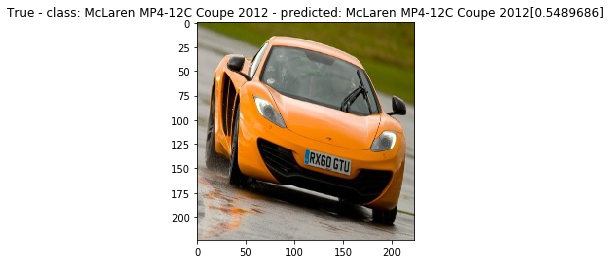

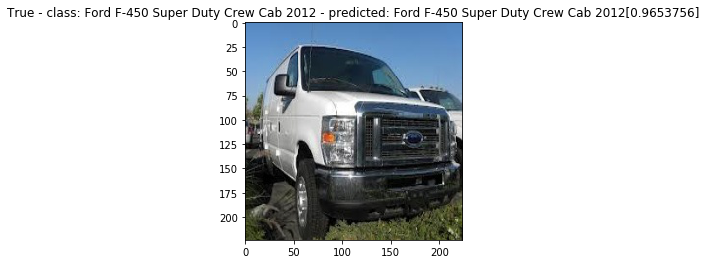

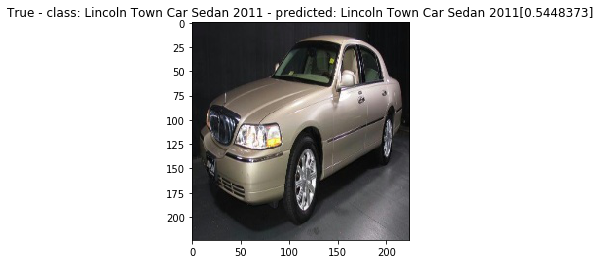

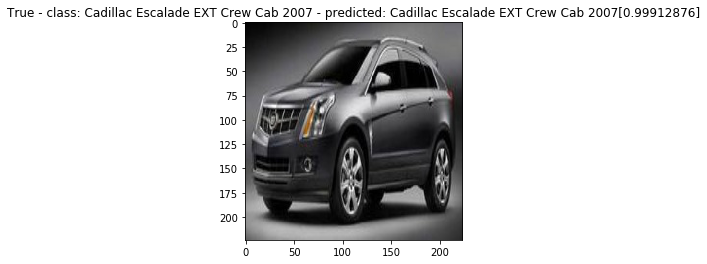

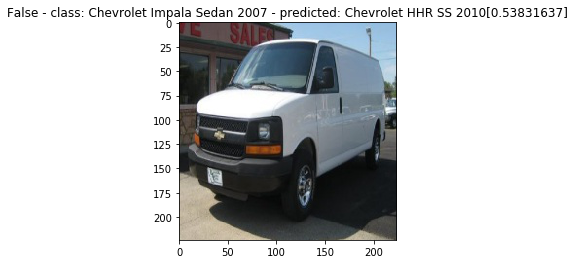

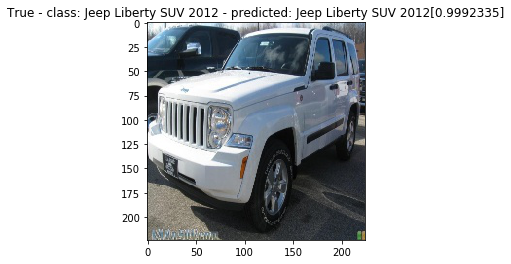

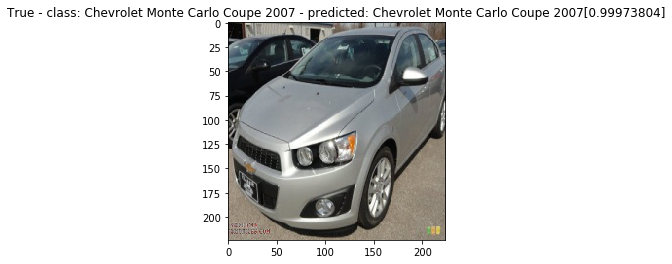

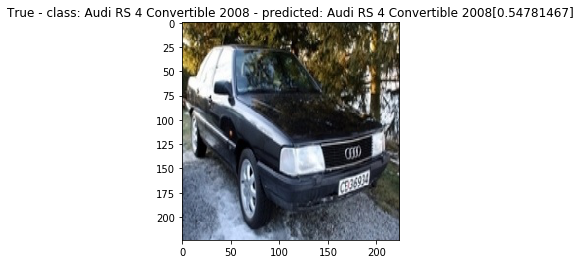

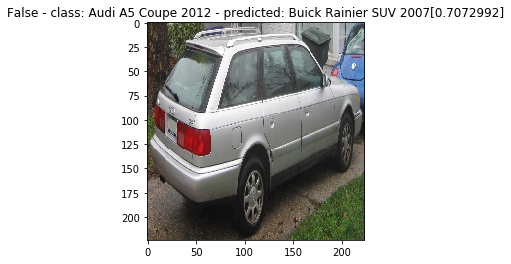

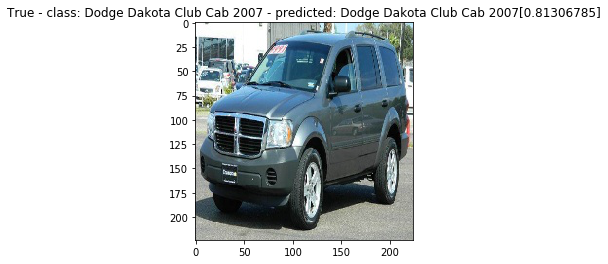

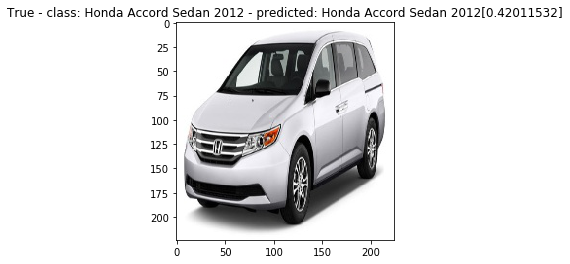

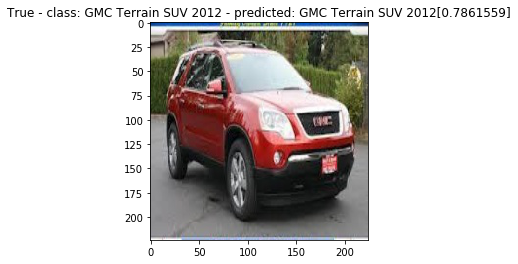

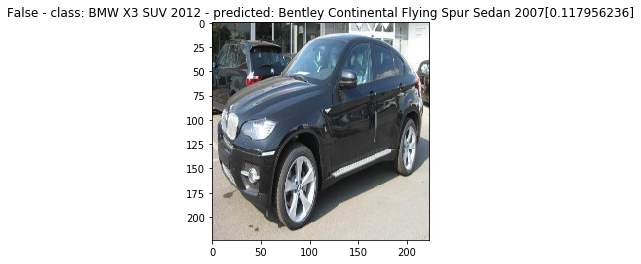

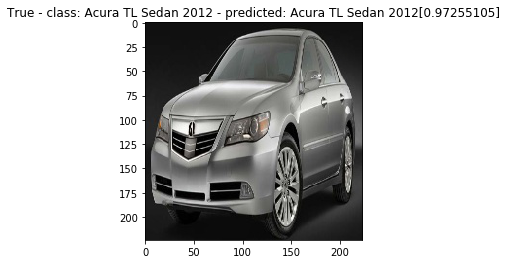

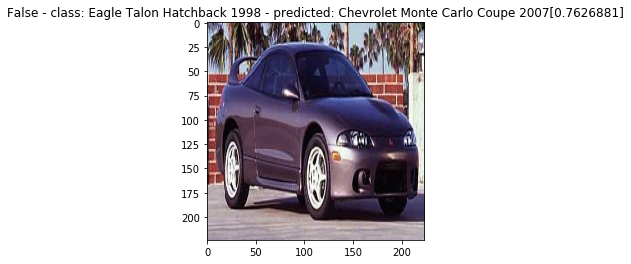

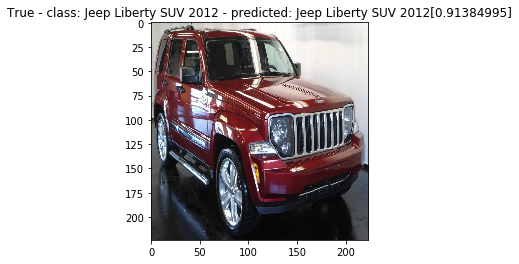

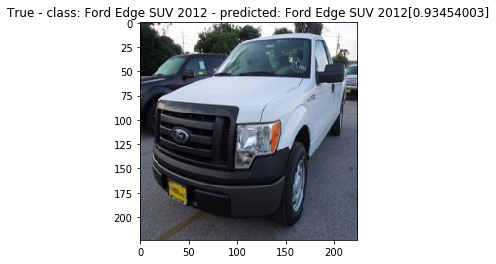

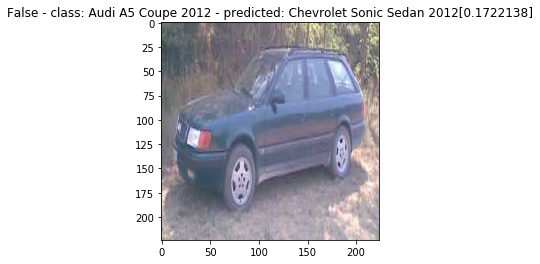

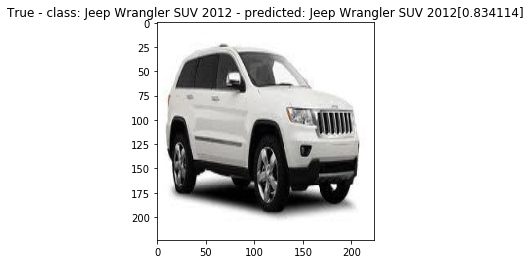

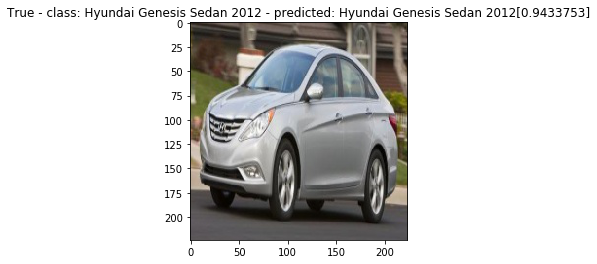

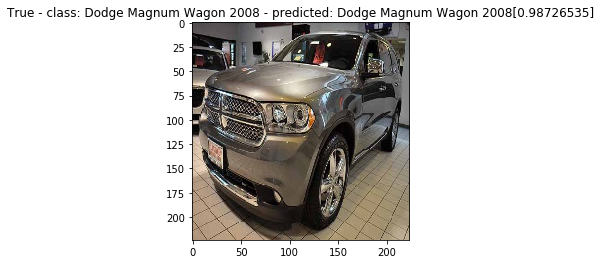

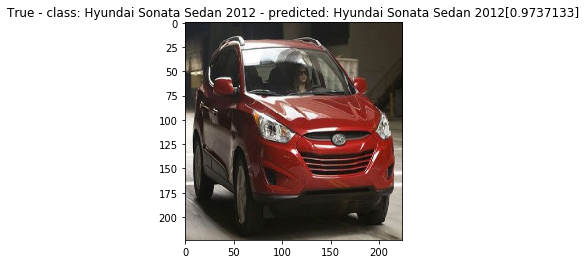

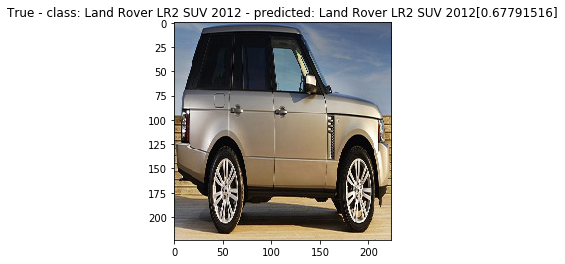

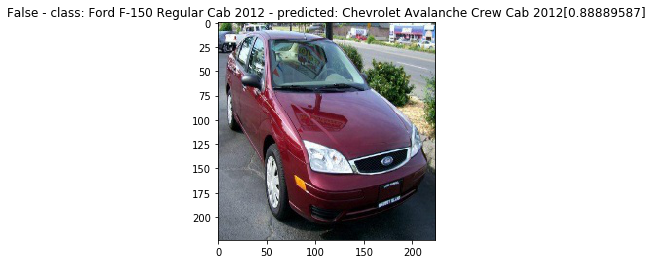

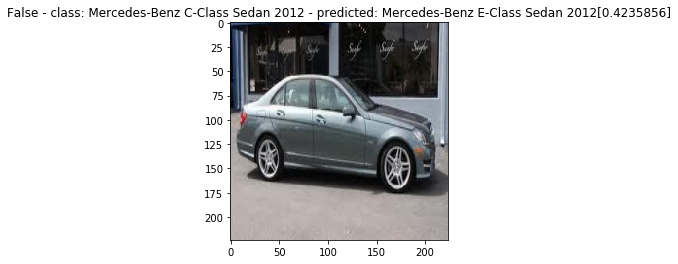

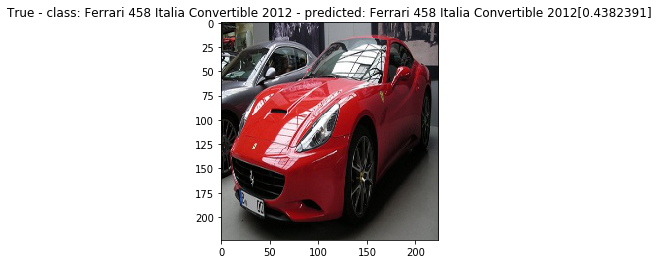

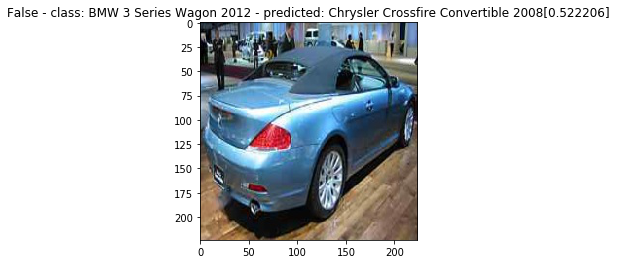

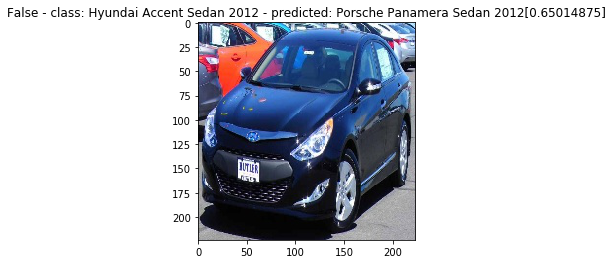

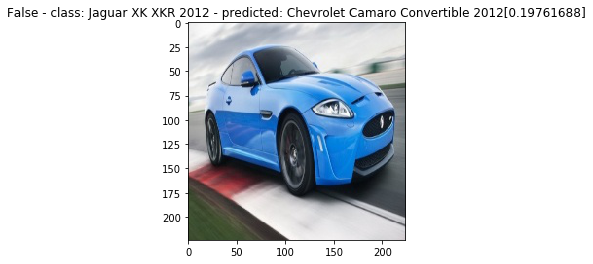

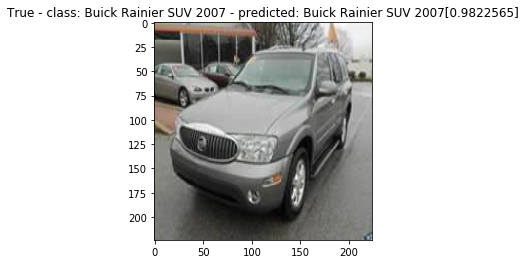

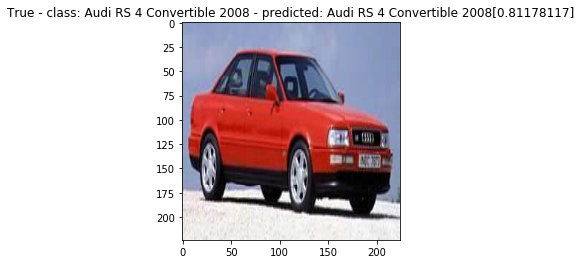

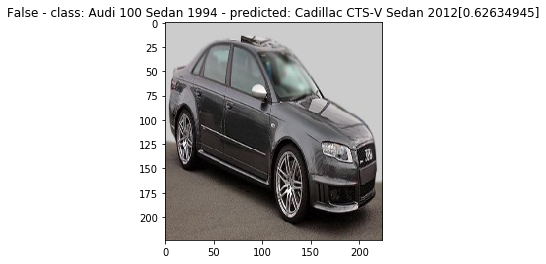

In [17]:
image_batch, classes_batch = next(validation_generator)
predicted_batch = model.predict(image_batch)

is_predicted_true = []

for k in range(0,image_batch.shape[0]):
    image = image_batch[k]
    pred = predicted_batch[k]
    the_pred = np.argmax(pred)
    predicted = classes_df['class'][the_pred]
    val_pred = max(pred)
    the_class = np.argmax(classes_batch[k])
    value = classes_df['class'][np.argmax(classes_batch[k])]
    plt.figure(k)
    isTrue = (the_pred == the_class)
    
    if isTrue:
        is_predicted_true.append(isTrue)
    
    plt.title(str(isTrue) + ' - class: ' + value + ' - ' + 'predicted: ' + predicted + '[' + str(val_pred) + ']')
    plt.imshow(image)

In [18]:
print('Predicted correct {} out of {} validation'.format(len(is_predicted_true), image_batch.shape[0]))

Predicted correct 21 out of 32 validation
